In [197]:
import pandas as pd
from sklearn import datasets, linear_model, metrics
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [151]:
train = pd.read_csv('../data/processed/train_data.csv')
test = pd.read_csv('../data/processed/test_data.csv')

In [161]:
#split input and output
X_train=train.drop(['SalePrice'], axis=1)
y_train= train['SalePrice']

X_test=test.drop(['SalePrice'], axis=1)
y_test= test['SalePrice']

In [163]:
#one hot encoding - convert categorical columns to numerical for linear regression. 
#there was an error with vanishing columns in test. This fixes it. 
X_train_one_hot = pd.get_dummies(X_train, drop_first=True) 
cols = X_train_one_hot.columns.tolist()
X_test_one_hot = pd.get_dummies(X_test, drop_first=True) 
X_test_one_hot = X_test_one_hot.reindex(columns=cols).fillna(0)


In [209]:
#Linear regression: 
#fit_intercept=False is needed as collinearity of one hot encoding, first row has to be dropped. 
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_one_hot, y_train)

LinearRegression(fit_intercept=False)

In [210]:
#predict sales price on test set
predictions_lm = reg.predict(X_test_one_hot)

In [211]:
#Apply inverse transformation to bring predictions back to the original scale
predictions_lm = np.exp(predictions_lm)

In [212]:
#RMSE 
rms = mean_squared_error(np.exp(y_test), predictions_lm, squared=False)
rms

198361.3569382523

In [ ]:
#tensorflow decision trees
#!pip install tensorflow_decision_forests

In [168]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="SalePrice", task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="SalePrice", task = tfdf.keras.Task.REGRESSION)

In [169]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model.compile


Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpg3mxo2jn as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x143517850>>

In [170]:
model.fit(train_ds)

Reading training dataset...


Training dataset read in 0:00:01.228226. Found 1165 examples.
Training model...


[INFO 24-12-31 10:15:50.7196 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpg3mxo2jn/model/ with prefix fca366e30d3c4cb5


Model trained in 0:00:02.100077
Compiling model...


[INFO 24-12-31 10:15:51.0528 GMT decision_forest.cc:734] Model loaded with 300 root(s), 111084 node(s), and 74 input feature(s).
[INFO 24-12-31 10:15:51.0543 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-12-31 10:15:51.0543 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [171]:
model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))

1/1 [==============================] - 1s 534ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [172]:
inspector = model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1165, accuracy=None, loss=None, rmse=0.15414591857731405, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
#note this RMSE is on the logarmithic data, not the actual data! 

In [173]:
#calculate the actual RMSE
preds = model.predict(test_ds)

1/1 [==============================] - 0s 233ms/step


In [174]:
predics=np.exp(preds)
y=test['SalePrice']

In [175]:
rms = mean_squared_error(np.exp(y), preds, squared=False)
rms

192198.77392215197

In [176]:

#next acitivity, explore all of these methods and compare RMSE of all

tfdf.keras.get_all_models()


[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [177]:
#GradientBoostedTreesModel - work in progress

In [178]:
#train model
model_gb_regression = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

model_gb_regression.fit(train_ds)

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpnktu0glr as temporary training directory
Reading training dataset...


[WARNING 24-12-31 10:16:27.3994 GMT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-12-31 10:16:27.4053 GMT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-12-31 10:16:27.4053 GMT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.991583. Found 1165 examples.
Training model...
Model trained in 0:00:02.332826
Compiling model...


[INFO 24-12-31 10:16:30.7227 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpnktu0glr/model/ with prefix d10aa32dbb734da5
[INFO 24-12-31 10:16:30.7340 GMT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-12-31 10:16:30.7362 GMT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-12-31 10:16:30.7362 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [181]:
# Make predictions on the same dataset (or test set)
predictions_log = model_gb_regression.predict(train_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_original_scale = np.exp(predictions_log)

# If you want to evaluate, you need to reverse the log transformation on the target values too
# For example, you could compare original-scale predictions with original-scale ground truth:
y_true = np.exp(train["SalePrice"])  # Reverse the log transformation on the target

2/2 [==============================] - 0s 8ms/step


In [182]:
rms = mean_squared_error(y_true, predictions_original_scale, squared=False)
rms

11341.401139976164

In [ ]:
#Cart model

In [183]:
#train model
model_cm_regression = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

model_cm_regression.fit(train_ds)

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpquu_c5un as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.104516. Found 1165 examples.
Training model...
Model trained in 0:00:00.201340
Compiling model...


[INFO 24-12-31 10:19:09.4000 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpquu_c5un/model/ with prefix a69ef024986c4bea
[INFO 24-12-31 10:19:09.4009 GMT decision_forest.cc:734] Model loaded with 1 root(s), 101 node(s), and 21 input feature(s).
[INFO 24-12-31 10:19:09.4010 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-12-31 10:19:09.4010 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [185]:
# Make predictions on the same dataset (or test set)
predictions_log_cm = model_cm_regression.predict(train_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_original_scale_cm = np.exp(predictions_log_cm)


2/2 [==============================] - 0s 15ms/step


In [186]:
rms = mean_squared_error(y_true, predictions_original_scale_cm, squared=False)
rms

32552.446266179526

In [ ]:
#basic RF

In [194]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train_one_hot, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [201]:
predictions_rf = regressor.predict(X_test_one_hot)
mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1077563045.8638906


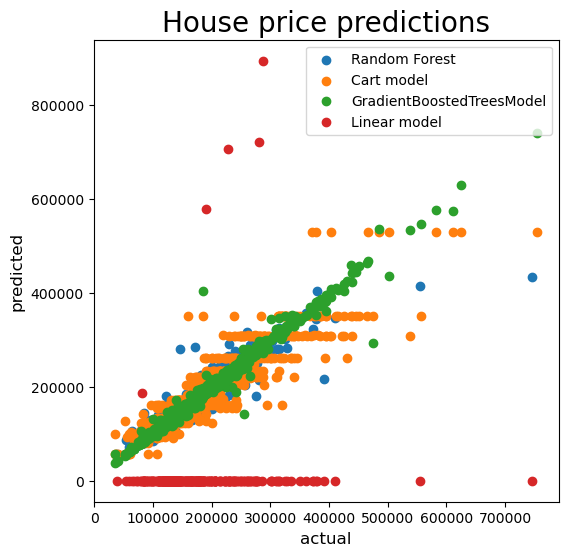

In [214]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title('House price predictions',fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(np.exp(y_test), np.exp(predictions_rf),label='Random Forest')
    ax.scatter(y_true, predictions_original_scale_cm,label='Cart model')
    ax.scatter(y_true, predictions_original_scale,label='GradientBoostedTreesModel')
    ax.scatter(np.exp(y_test), predictions_lm,label='Linear model')
    ax.legend()
